# Persistent Homology of Sliding Windows

Now that we have heuristically explored the geometry of sliding window embeddings of 1D signals, we will apply tools from persistent homology to quantify the geometry.  As before, we first need to import all necessary libraries and setup code to compute sliding window embeddings

In [2]:
# Do all of the imports and setup inline plotting
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA

import scipy.interpolate as interp

import ipywidgets as widgets
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output

from ripser import ripser, plot_dgms

# Setup the sliding window code
def getSlidingWindow(x, dim, Tau, dT):
    N = len(x)
    NWindows = int(np.floor((N-dim*Tau)/dT)) # The number of windows
    if NWindows <= 0:
        print("Error: Tau too large for signal extent")
        return np.zeros((3, dim))
    X = np.zeros((NWindows, dim)) # Create a 2D array which will store all windows
    idx = np.arange(N)
    for i in range(NWindows):
        # Figure out the indices of the samples in this window
        idxx = dT*i + Tau*np.arange(dim) 
        start = int(np.floor(idxx[0]))
        end = int(np.ceil(idxx[-1]))+2
        if end >= len(x):
            X = X[0:i, :]
            break
        # Do spline interpolation to fill in this window, and place
        # it in the resulting array
        X[i, :] = interp.spline(idx[start:end+1], x[start:end+1], idxx)
    return X

# Single Sine: Maximum Persistence vs Window Size

First, let's examine the 1D persistent homology of the sliding window embedding of a single perfect sinusoid.  Choose dim and $\tau$ to change the extent (window size) to different values, and examine how the maximum persistence changes.  How does this support what you saw in the first module?

<IPython.core.display.Javascript object>


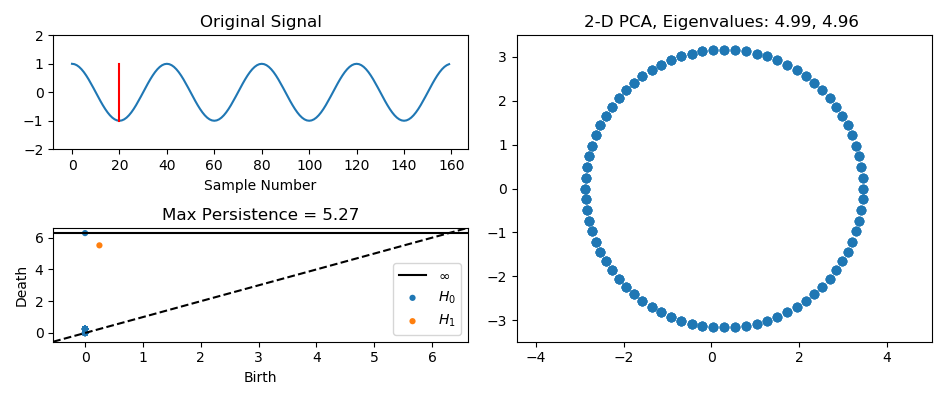

In [5]:
def on_value_change(change):
    execute_computation1()
    
dimslider = widgets.IntSlider(min=1,max=100,value=20,description='Dimension:',continuous_update=False)
dimslider.observe(on_value_change, names='value')

Tauslider = widgets.FloatSlider(min=0.1,max=5,step=0.1,value=1,description=r'\(\tau :\)' ,continuous_update=False)
Tauslider.observe(on_value_change, names='value')

noiseampslider = widgets.FloatSlider(min=0,max=2,step=0.1,value=0,description='Noise Amplitude',continuous_update=False)
noiseampslider.observe(on_value_change, names='value')

display(widgets.HBox(( dimslider,Tauslider, noiseampslider)))

noise = np.random.randn(10000)

def execute_computation1():
    
    # Step 1: Setup the signal
    T = 40 # The period in number of samples
    NPeriods = 4 # How many periods to go through
    N = T*NPeriods # The total number of samples
    t = np.linspace(0, 2*np.pi*NPeriods, N+1)[0:N] # Sampling indices in time
    x = np.cos(t) # The final signal
    x += noiseampslider.value * noise[:len(x)]
    
    clear_output()
    
    # Step 2: Do a sliding window embedding
    dim = dimslider.value
    Tau = Tauslider.value
    dT = 0.5
    X = getSlidingWindow(x, dim, Tau, dT)
    extent = Tau*dim

    # Step 3: Do Rips Filtration
    PDs = ripser(X, maxdim=1)['dgms']
    I = PDs[1]

    # Step 4: Perform PCA down to 2D for visualization
    pca = PCA(n_components = 2)
    Y = pca.fit_transform(X)
    eigs = pca.explained_variance_

    # Step 5: Plot original signal, 2-D projection, and the persistence diagram
    fig = plt.figure(figsize=(9.5, 4))
    gs = gridspec.GridSpec(2, 2)
    ax = plt.subplot(gs[0,0])
    ax.plot(x)
    ax.set_ylim((2*min(x), 2*max(x)))
    ax.set_title("Original Signal")
    ax.set_xlabel("Sample Number")
    ax.plot([extent, extent], [np.min(x), np.max(x)], 'r')

    ax2 = plt.subplot(gs[1,0])
    plot_dgms(PDs)
    plt.title("Max Persistence = %.3g"%np.max(I[:, 1] - I[:, 0]))
    
    ax3 = plt.subplot(gs[:,1])
    ax3.scatter(Y[:, 0], Y[:, 1])
    plt.axis('equal')
    plt.title("2-D PCA, Eigenvalues: %.3g, %.3g "%(eigs[0],eigs[1]))
    
    plt.tight_layout()
    
execute_computation1()

## Questions
1. Examining the effect of window extent on maximal persistence (with no noise):
  1. Describe the effect of dimension and $\tau$ on maximal persistence. What does increasing one of these factors while keeping the other constant to do the window extent? What does it do to the maximal persistence? Explain your observations.
  1. Is the maximal persistence a function of the window extent? Justify your answer and explain it geometrically (you may want to refer to the PCA projection plots).
  1. Describe the relation between the eigenvalues and the maximal persistence. (Hint: How do the eigenvalues affect roundness? How does roundness affect persistence?)
  1. Write code to plot scatter plots of maximal persistence vs dimension for fixed $\tau$ and vs $\tau$ for fixed dimension, and maximal persistence vs. dimension for fixed extent (say, extent = 40). Comment on your results.
<br><br>
1. Now add some noise to your plots. Notice that the maximal persistence point on the persistence diagram is colored in red.
  1. What do you observe regarding the persistence diagram? Explain your observations in terms of your understading of persistence.
  1. At what noise amplitude does the point with maximal persistence appear to get 'swallowed up' by the noise in the diagram? How does this correspond with the 2-D projection?
  1. Note that the original signal has amplitude 1. As you increase noise, is it clear by looking at the signal that there is a periodic function underlying it? How does persistence allow detection of periodicity? Explain.
  1. For fixed noise amplitude (say 1), increase dimension. What effect does this have on detection of periodicity using your method?
  1. Does varying $\tau$ for the same fixed amplitude have the same effect? Explain.

<IPython.core.display.Javascript object>


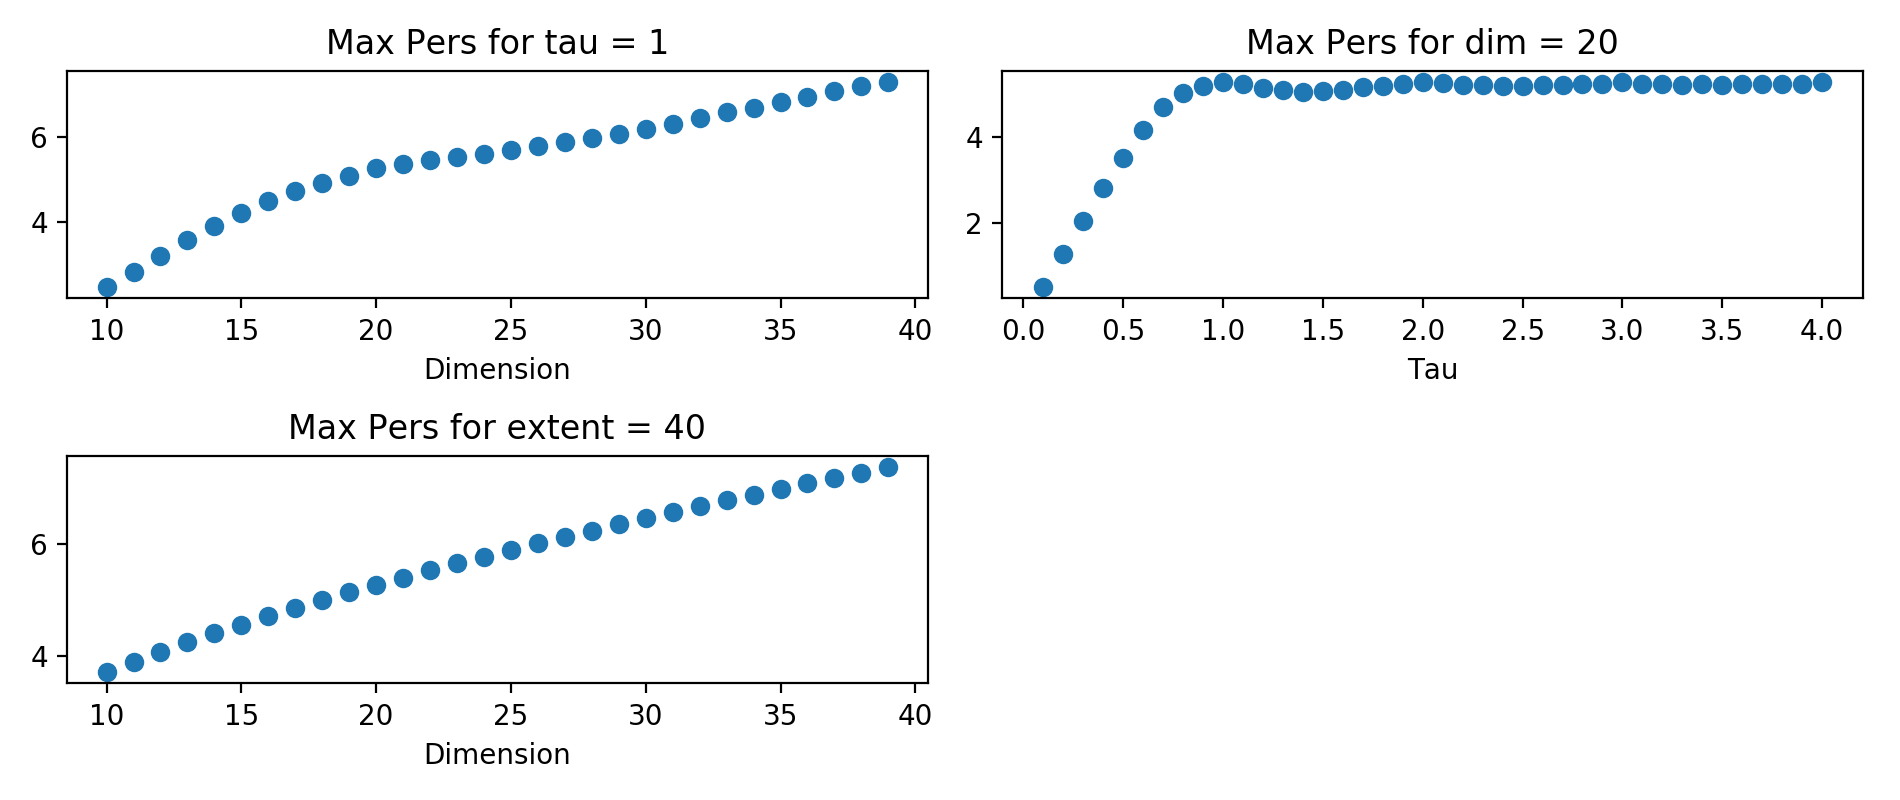

In [20]:
Tau = 1.
dT = 0.5
xs = []
ys = []
T = 40 # The period in number of samples
NPeriods = 4 # How many periods to go through
N = T*NPeriods # The total number of samples
t = np.linspace(0, 2*np.pi*NPeriods, N+1)[0:N] # Sampling indices in time
x = np.cos(t) # The final signal

for dim in range(10,40):
    X = getSlidingWindow(x, dim, Tau, dT)
    PDs = doRipsFiltration(X, 1)
    I = PDs[1]
    xs.append(dim)
    ys.append(np.max(I[:, 1] - I[:, 0]))


fig = plt.figure(figsize=(9.5,4))
ax = plt.subplot(221)
plt.scatter(xs,ys)
ax.set_title("Max Pers for tau = 1")
ax.set_xlabel("Dimension")

xs = []
ys = []
dim = 20

for Tau in np.linspace(0.1,4,40):
    X = getSlidingWindow(x, dim, Tau, dT)
    PDs = doRipsFiltration(X, 1)
    I = PDs[1]
    xs.append(Tau)
    ys.append(np.max(I[:, 1] - I[:, 0]))

ax2 = plt.subplot(222)
plt.scatter(xs,ys)
ax2.set_title("Max Pers for dim = 20")
ax2.set_xlabel("Tau")

xs = []
ys = []

for dim in range(10,40):
    Tau = 40./dim
    X = getSlidingWindow(x, dim, Tau, dT)
    PDs = doRipsFiltration(X, 1)
    I = PDs[1]
    xs.append(dim)
    ys.append(np.max(I[:, 1] - I[:, 0]))

ax3 = plt.subplot(223)
plt.scatter(xs,ys)
ax3.set_title("Max Pers for extent = 40")
ax3.set_xlabel("Dimension")

plt.tight_layout();

## Two Sines

Now let's examine the persistent homology of a signal consisting of the sum of two sinusoids.  First, setup and examine the signal.  We will use a slightly coarser sampling rate than we did in the first module to keep the persistent homology code running quickly.

<IPython.core.display.Javascript object>


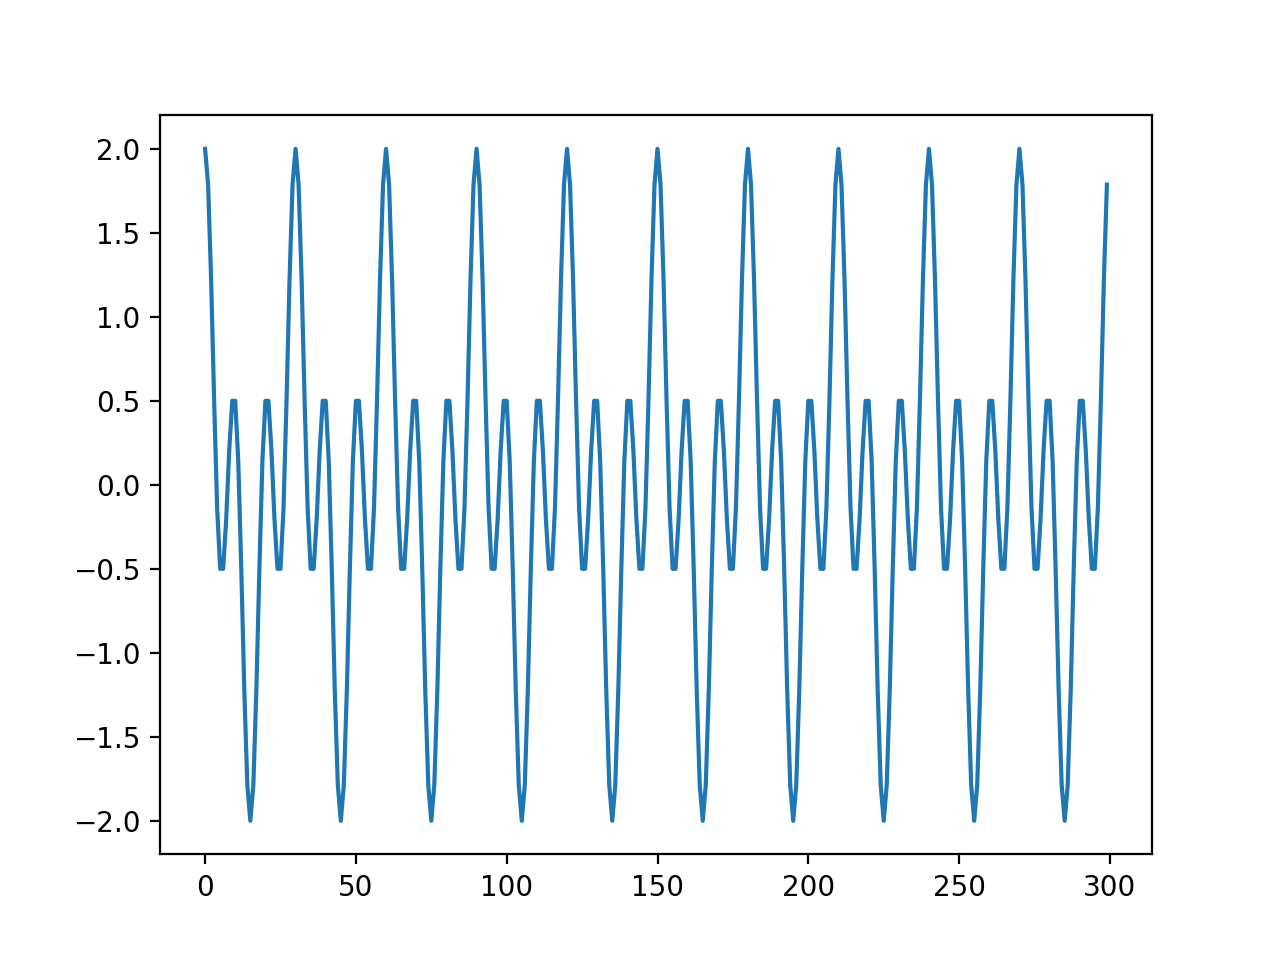

In [27]:
# Step 1: Setup the signal
T1 = 10 # The period of the first sine in number of samples
T2 = T1*3 # The period of the second sine in number of samples
NPeriods = 10 # How many periods to go through, relative to the second sinusoid
N = T2*NPeriods # The total number of samples
t = np.arange(N) # Time indices
x = np.cos(2*np.pi*(1.0/T1)*t) # The first sinusoid
x += np.cos(2*np.pi*(1.0/T2)*t) # The second sinusoid
plt.figure();
plt.plot(x);

### Persistent Homology

Now, we will compute the persistent homology of the above signal following a sliding window embedding.  Run this code. Then examine the outputs with both harmonic sinusoids and noncommensurate sinusoids, and note the difference in the persistence diagrams. Note that the two points with highest persistence are highlighted in red on the diagram.

<IPython.core.display.Javascript object>


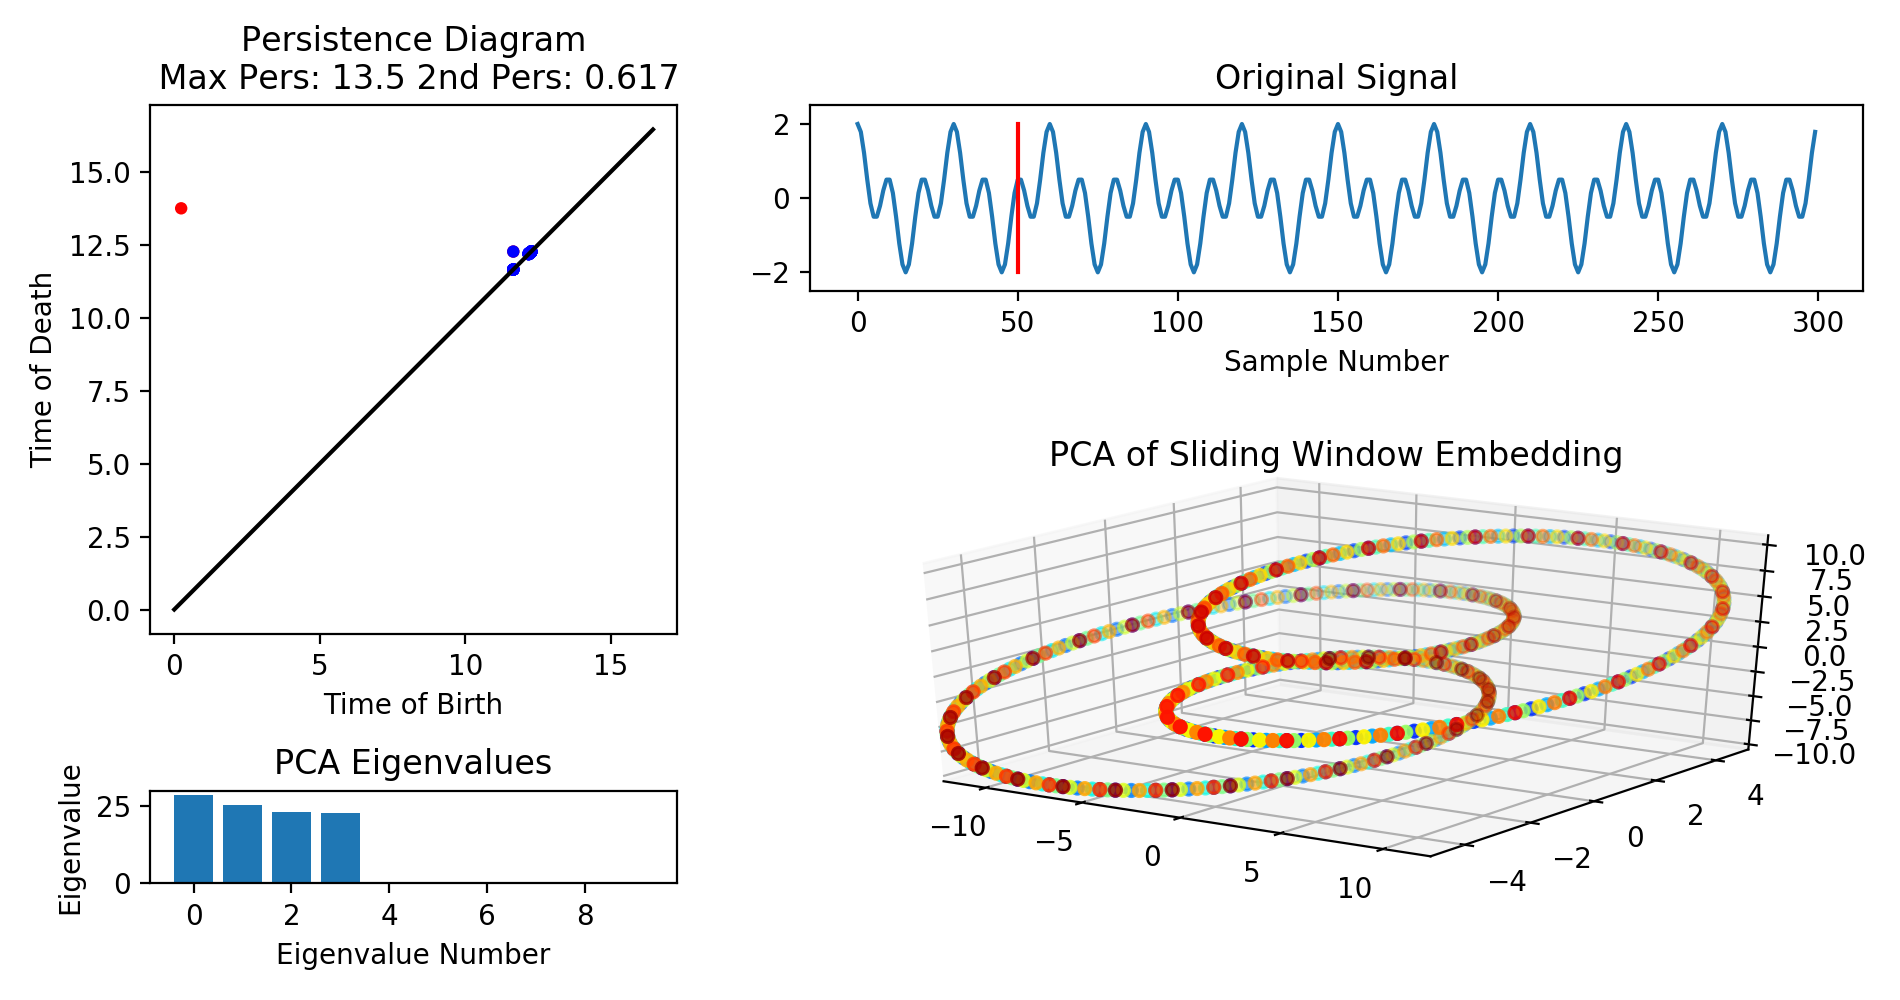

In [44]:
def on_value_change(change):
    execute_computation3()

secondfreq = widgets.Dropdown(options=[ 2, 3, np.pi],value=3,description='Second Frequency:',disabled=False)
secondfreq.observe(on_value_change,names='value')

noiseampslider = widgets.FloatSlider(min=0,max=2,step=0.1,value=0,description='Noise Amplitude',continuous_update=False)
noiseampslider.observe(on_value_change, names='value')

dimslider = widgets.IntSlider(min=1,max=100,value=20,description='Dimension:',continuous_update=False)
dimslider.observe(on_value_change, names='value')

Tauslider = widgets.FloatSlider(min=0.1,max=5,step=0.1,value=1,description=r'\(\tau :\)' ,continuous_update=False)
Tauslider.observe(on_value_change, names='value')

display(widgets.HBox(( dimslider,Tauslider)))
display(widgets.HBox(( secondfreq,noiseampslider)))

noise = np.random.randn(10000)

def execute_computation3():
    clear_output()
    # Step 1: Setup the signal
    T1 = 10 # The period of the first sine in number of samples
    T2 = T1*secondfreq.value # The period of the second sine in number of samples
    NPeriods = 10 # How many periods to go through, relative to the second sinusoid
    N = T2*NPeriods # The total number of samples
    t = np.arange(N) # Time indices
    x = np.cos(2*np.pi*(1.0/T1)*t) # The first sinusoid
    x += np.cos(2*np.pi*(1.0/T2)*t) # The second sinusoid
    x += noiseampslider.value * noise[:len(x)]

    #Step 2: Do a sliding window embedding
    dim = dimslider.value
    Tau = Tauslider.value
    dT = 0.35
    X = getSlidingWindow(x, dim, Tau, dT)
    extent = Tau*dim

    #Step 3: Do Rips Filtration
    PDs = doRipsFiltration(X, 1)

    #Step 4: Perform PCA down to 2D for visualization
    pca = PCA()
    Y = pca.fit_transform(X)
    eigs = pca.explained_variance_

    #Step 5: Plot original signal and the persistence diagram
    fig = plt.figure(figsize=(9.5, 5))
    gs = gridspec.GridSpec(3, 2,width_ratios=[1, 2],height_ratios=[2,2,1])
    
    ax = plt.subplot(gs[0,1])
    ax.plot(x)
    ax.set_ylim((1.25*min(x), 1.25*max(x)))
    ax.set_title("Original Signal")
    ax.set_xlabel("Sample Number")
    #ax.hold(True)
    ax.plot([extent, extent], [np.min(x), np.max(x)], 'r')

    ax2 = plt.subplot(gs[0:2,0])
    plotDGM(PDs[1],highlight = 2)
    maxind = np.argpartition(PDs[1][:,1]-PDs[1][:,0], -2)[-2:]
    max1 = PDs[1][maxind[1],1] -  PDs[1][maxind[1],0]
    max2 = PDs[1][maxind[0],1] -  PDs[1][maxind[0],0]
    ax2.set_title("Persistence Diagram\n Max Pers: %.3g 2nd Pers: %.3g"%(max1,max2) )

    ax3 = plt.subplot(gs[2,0])
    eigs = eigs[0:min(len(eigs), 10)]
    ax3.bar(np.arange(len(eigs)), eigs)
    ax3.set_xlabel("Eigenvalue Number")
    ax3.set_ylabel("Eigenvalue")
    ax3.set_title("PCA Eigenvalues")

    c = plt.get_cmap('jet')
    C = c(np.array(np.round(np.linspace(0, 255, Y.shape[0])), dtype=np.int32))
    C = C[:, 0:3]
    ax4 = fig.add_subplot(gs[1:,1], projection = '3d')
    ax4.set_title("PCA of Sliding Window Embedding")
    ax4.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=C)
    ax4.set_aspect('equal', 'datalim')
    
    plt.tight_layout()

execute_computation3()

#### Questions

1. Describe a key difference in the persistence diagrams between the harmonic and non-commensurate cases. Explain this difference in terms of the 3-D projection of the PCA embedding. (Hint: consider the shape and the intrinsic dimension of the projection.)
<br><br>
1. Explain how the persistence diagram allows the detection of non-commensurate sinusoids.
<br><br>
1. Can the persistence diagram distinguish between a single sinusoid and the sum of two harmonic sinusoids?
<br><br>
1. Looking back at the 2-D projection of the PCA in the harmonic case from the first lab, explain why the persistence diagram might be surprising if you had only seen that projection. How does looking at the 3-D projection make the persistence diagram less of a surprise?

<h1>Field of Coefficients</h1><BR>

Now we will examine a surprising geometric property that is able to tell apart two signals which look quite similar.  First, we generate and plot the two signals below:

$$g_1 = 0.6\cos(t) + 0.8\cos(2t)$$

$$g_2 = 0.8\cos(t) + 0.6\cos(2t)$$

<IPython.core.display.Javascript object>


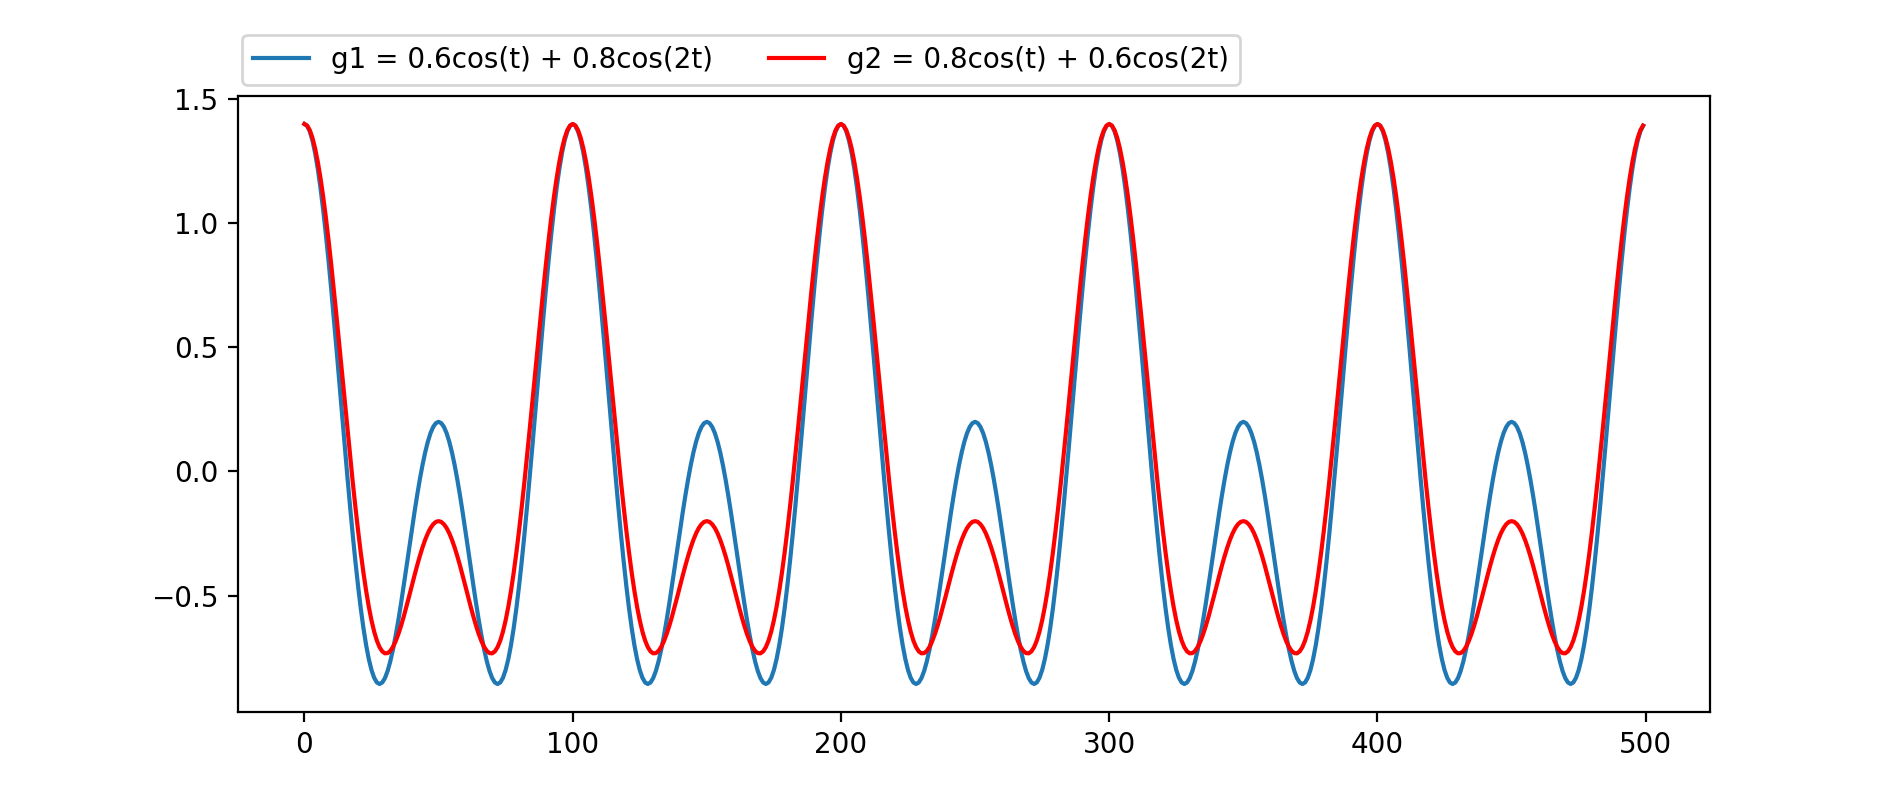

In [5]:
# Step 1: Setup the signal
T1 = 100 # The period of the first sine in number of samples
T2 = 50
NPeriods = 5 # How many periods to go through, relative to the first sinusoid
N = T1*NPeriods # The total number of samples
t = np.arange(N) # Time indices
coeff1 = 0.6
coeff2 = 0.8
g1 = coeff1*np.cos(2*np.pi*(1.0/T1)*t) # The first sinusoid
g1 += coeff2*np.cos(2*np.pi*(1.0/T2)*t) # The second sinusoid

g2 = coeff2*np.cos(2*np.pi*(1.0/T1)*t) # The first sinusoid
g2 += coeff1*np.cos(2*np.pi*(1.0/T2)*t) # The second sinusoid

fig = plt.figure(figsize=(9.5, 4))
plot1, = plt.plot(g1,label="g1 = %.2gcos(t) + %.2gcos(2t)"%(coeff1, coeff2))
plot2, = plt.plot(g2,color='r',label="g2 = %.2gcos(t) + %.2gcos(2t)"%(coeff2, coeff1));
plt.legend(handles=[plot1,plot2])
plt.legend(bbox_to_anchor=(0., 1.02, 0.69, .102), ncol=2);

Now, we will look at PCA of the sliding window embeddings of the two signals

<IPython.core.display.Javascript object>


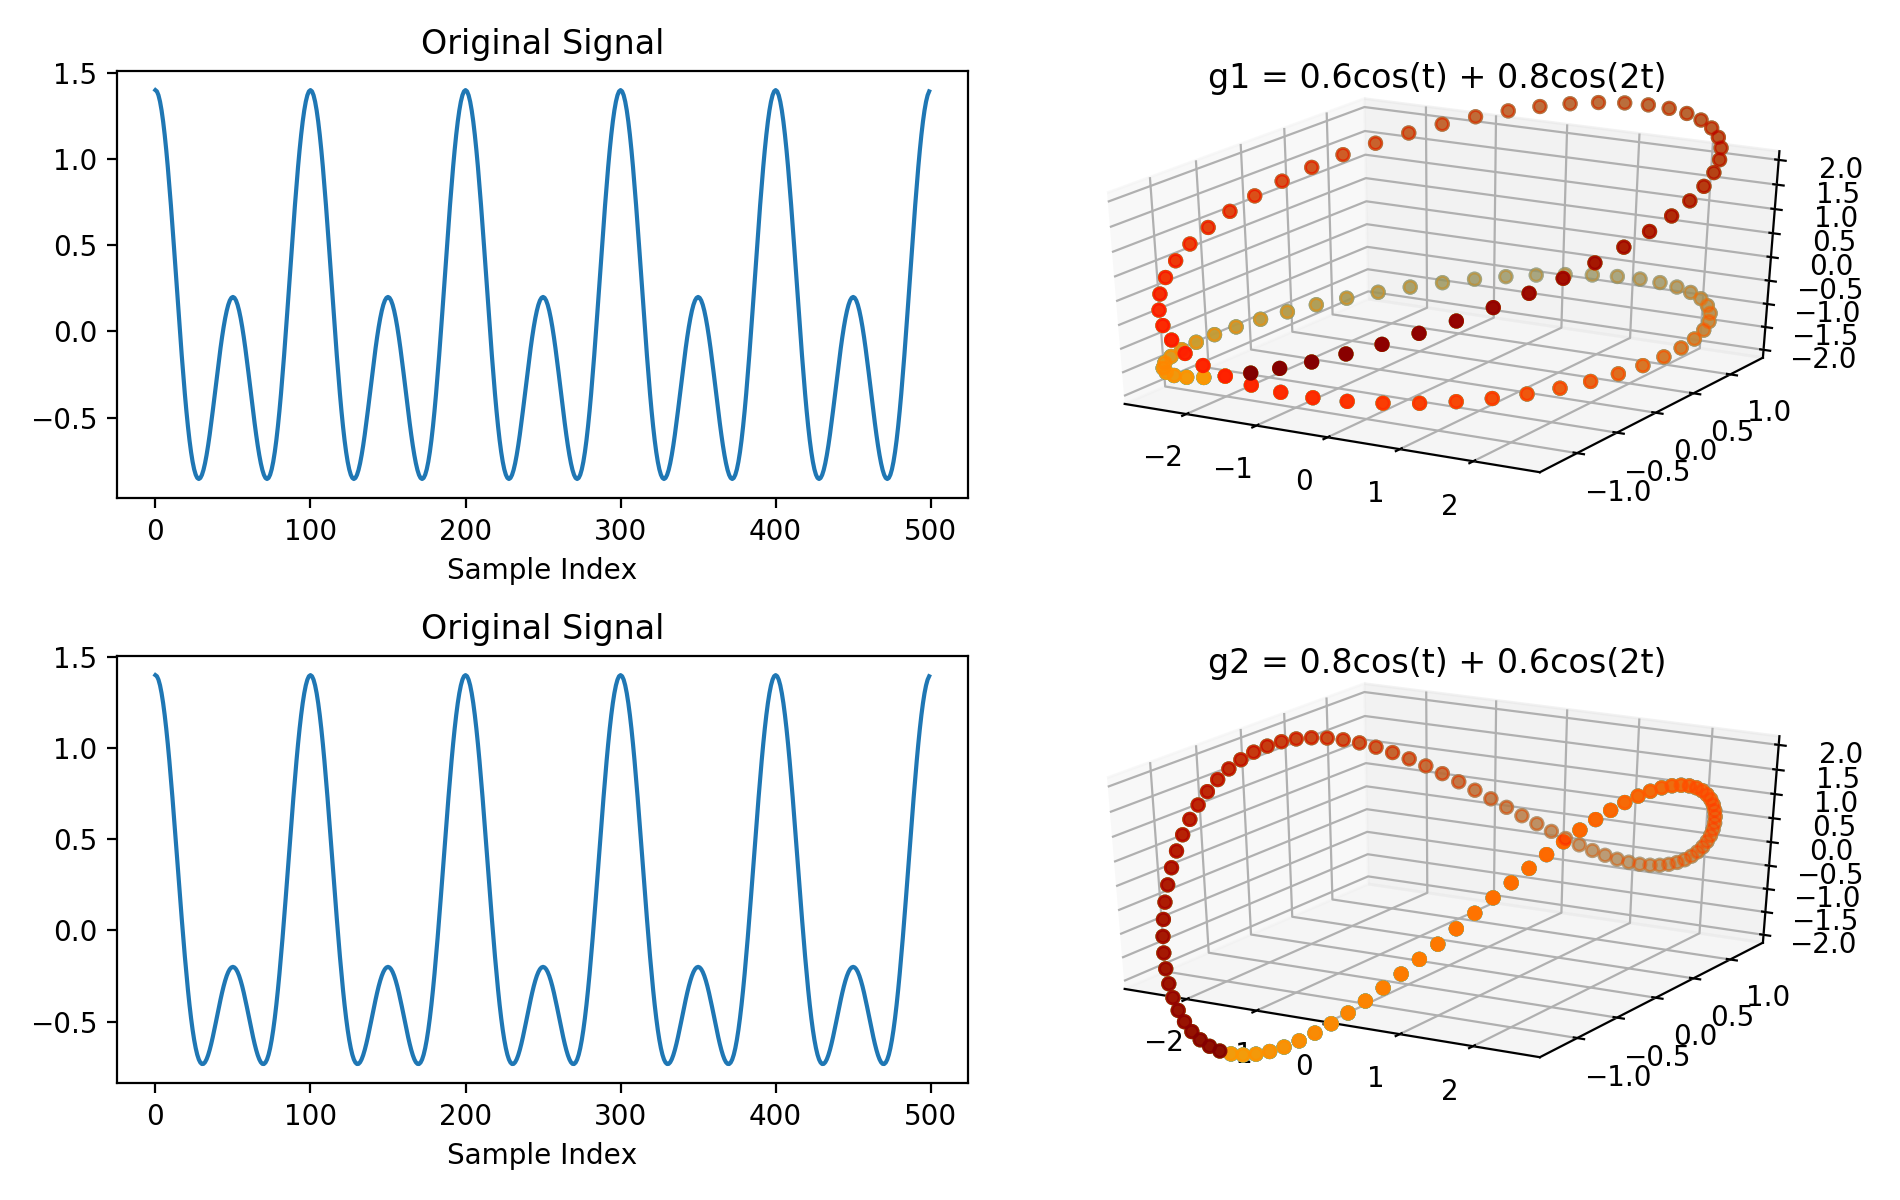

In [6]:
####g1
#Step 2: Do a sliding window embedding
dim = 20
Tau = 5
dT = 1
X1 = getSlidingWindow(g1, dim, Tau, dT)

#Step 3: Perform PCA down to 2D for visualization
pca = PCA()
Y = pca.fit_transform(X1)
eigs = pca.explained_variance_

c = plt.get_cmap('jet')
C = c(np.array(np.round(np.linspace(0, 255, Y.shape[0])), dtype=np.int32))
C = C[:, 0:3]

#Step 4: Plot original signal and PCA of the embedding
fig = plt.figure(figsize=(9.5,6))
ax = fig.add_subplot(221)
ax.plot(g1)
ax.set_title("Original Signal")
ax.set_xlabel("Sample Index")

ax2 = fig.add_subplot(222, projection = '3d')
ax2.set_title("g1 = %.2gcos(t) + %.2gcos(2t)"%(coeff1, coeff2))
ax2.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=C)
ax2.set_aspect('equal', 'datalim')

#####g2
X2 = getSlidingWindow(g2, dim, Tau, 1)
#Perform PCA down to 2D for visualization
pca = PCA()
Y = pca.fit_transform(X2)
eigs = pca.explained_variance_

ax = fig.add_subplot(223)
ax.plot(g2)
ax.set_title("Original Signal")
ax.set_xlabel("Sample Index")

ax2 = fig.add_subplot(224, projection = '3d')
ax2.set_title("g2 = %.2gcos(t) + %.2gcos(2t)"%(coeff2, coeff1))
ax2.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=C)
ax2.set_aspect('equal', 'datalim')
plt.tight_layout();

Notice how one looks more "twisted" than the other.  To finish this off, let's compute TDA

Computing persistence diagrams for g1...
Computing persistence diagrams for g2...


<IPython.core.display.Javascript object>


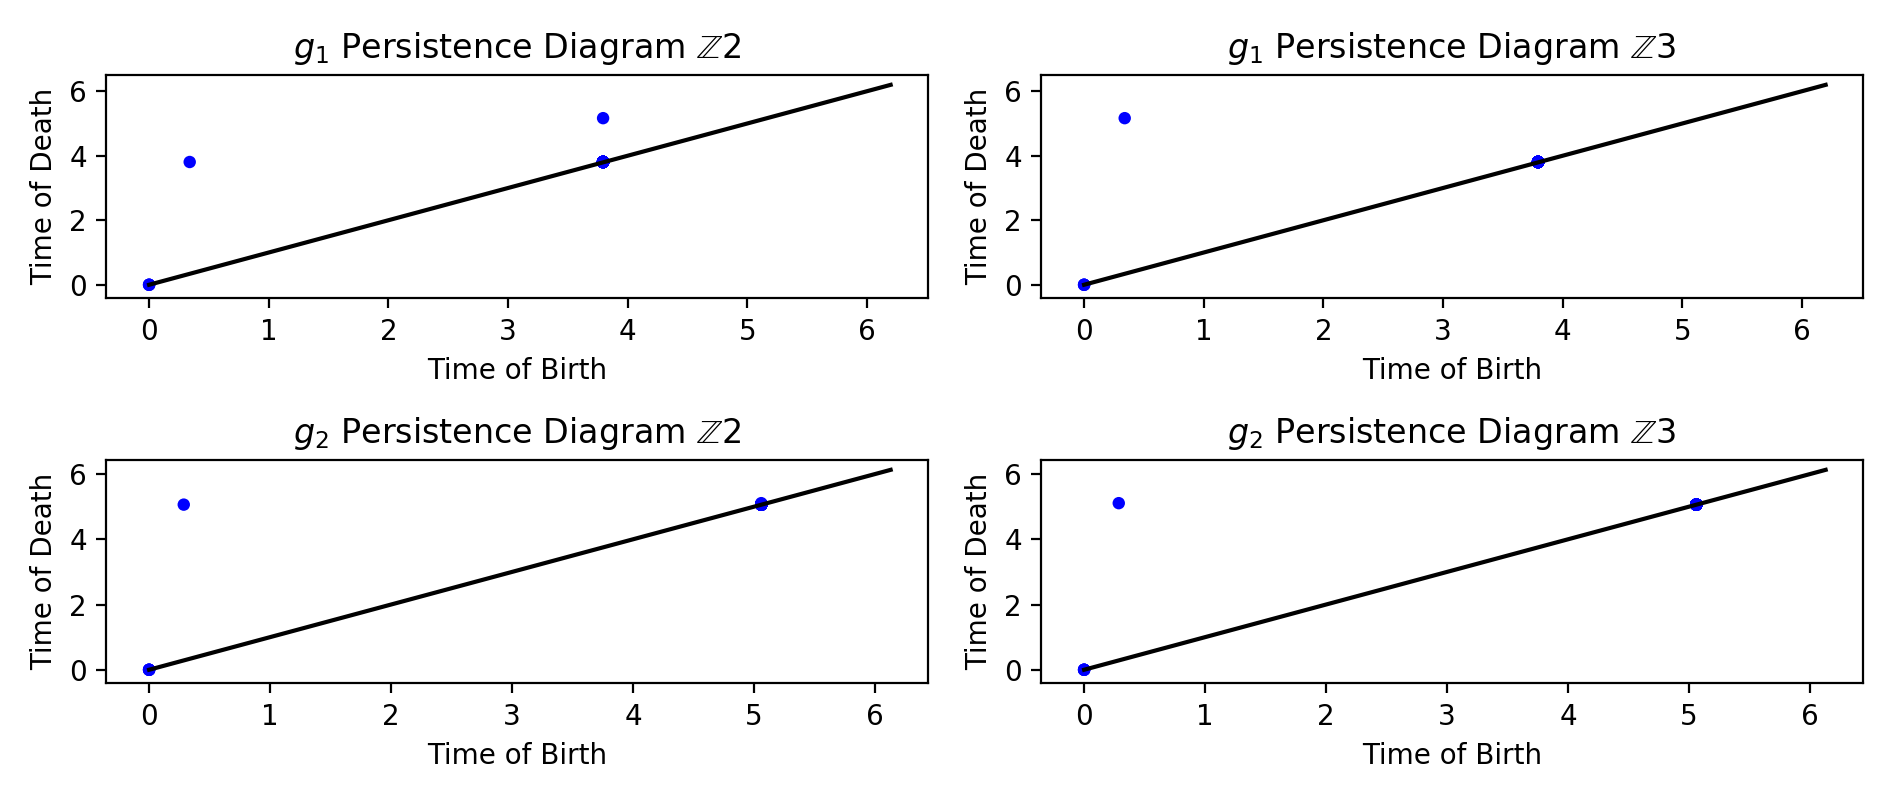

In [7]:
#Step 1: Do rips filtrations with different field coefficients
print("Computing persistence diagrams for g1...")
PDs1_2 = doRipsFiltration(X1, 1, coeff = 2) #Z2 Coefficients
PDs1_3 = doRipsFiltration(X1, 1, coeff = 3) #Z3 Coefficients
print("Computing persistence diagrams for g2...")
PDs2_2 = doRipsFiltration(X2, 1, coeff = 2)
PDs2_3 = doRipsFiltration(X2, 1, coeff = 3)


fig = plt.figure(figsize=(9.5, 4))


plt.subplot(221);
plotDGM(PDs1_2[1])
plt.title("$g_1$ Persistence Diagram $\mathbb{Z}2$")

plt.subplot(222);
plotDGM(PDs1_3[1])
plt.title("$g_1$ Persistence Diagram $\mathbb{Z}3$")

plt.subplot(223);
plotDGM(PDs2_2[1])
plt.title("$g_2$ Persistence Diagram $\mathbb{Z}2$")

plt.subplot(224);
plotDGM(PDs2_3[1])
plt.title("$g_2$ Persistence Diagram $\mathbb{Z}3$")

plt.tight_layout();

As can be seen in the corresponding persistence diagrams below, g<SUB>1</SUB>(t) changes when Z mod 3 coefficients are used, while g<SUB>2</SUB>(t) stays the same.  This is because g<SUB>1</SUB>(t) is the boundary of a moebius strip.

<h1>Summary</h1>
<ul>
<li>Persistence diagrams are a summary for the geometry/topology of the sliding window embedding</li>
<li>Maximum persistence is maximized when window size is close to period</li>
<li>Surprisingly, the maximum persistence of signals with harmonics depends on the field of coefficients</li>
</ul>